In [ ]:
# Cell 1: Environment setup
!nvidia-smi

# Install core dependencies (PyTorch + tools)
!pip install --quiet torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install --quiet opencv-python tqdm onnx onnxruntime-gpu
!pip install addict scikit-learn pathspec imagesize ujson tensorboard
!pip install onnxscript
!pip install --quiet "qai-hub" pillow

In [ ]:
# Clone UFLDv2 repo
%cd /content
!git clone https://github.com/cfzd/Ultra-Fast-Lane-Detection-v2.git
%cd Ultra-Fast-Lane-Detection-v2

In [ ]:
# Download KITTI raw subset for benchmarking
import os
import zipfile
from pathlib import Path
from tqdm.auto import tqdm
import requests

ROOT = Path.cwd()
DATASETS_ROOT = ROOT / "datasets"
DOWNLOADS_DIR = DATASETS_ROOT / "downloads"
KITTI_RAW_DIR = DATASETS_ROOT / "kitti_raw"

for d in [DATASETS_ROOT, DOWNLOADS_DIR, KITTI_RAW_DIR]:
    d.mkdir(parents=True, exist_ok=True)

# KITTI raw datasets
kitti_urls = [
    "https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_drive_0015/2011_09_26_drive_0015_sync.zip",
    "https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_drive_0027/2011_09_26_drive_0027_sync.zip",
    "https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_drive_0028/2011_09_26_drive_0028_sync.zip",
    "https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_drive_0029/2011_09_26_drive_0029_sync.zip",
    "https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_drive_0032/2011_09_26_drive_0032_sync.zip",
    "https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_drive_0052/2011_09_26_drive_0052_sync.zip",
]

def download_file(url, out_dir):
    local_path = out_dir / url.split("/")[-1]
    if local_path.exists():
        print(f"[SKIP] Already exists: {local_path.name}")
        return local_path

    print(f"\nDownloading: {url}")
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        total = int(r.headers.get("content-length", 0))
        block_size = 1024
        with open(local_path, "wb") as f, tqdm(total=total, unit="B", unit_scale=True, desc=local_path.name) as pbar:
            for chunk in r.iter_content(block_size):
                f.write(chunk)
                pbar.update(len(chunk))
    return local_path

def extract_zip(zip_path, extract_to):
    print(f"Extracting {zip_path.name} -> {extract_to}")
    with zipfile.ZipFile(zip_path, 'r') as zf:
        zf.extractall(extract_to)

for url in kitti_urls:
    zip_file = download_file(url, DOWNLOADS_DIR)
    extract_zip(zip_file, KITTI_RAW_DIR)

print("\nKITTI raw subset downloaded to:", KITTI_RAW_DIR)
!find datasets/kitti_raw -maxdepth 2 -type d | head


In [ ]:
# Create weights directory and upload Tusimple ResNet18
from pathlib import Path

WEIGHTS_DIR = Path("weights")
WEIGHTS_DIR.mkdir(exist_ok=True)


In [ ]:
%cd /content/Ultra-Fast-Lane-Detection-v2

/content/Ultra-Fast-Lane-Detection-v2


In [ ]:
# Preprocess KITTI frames for UFLDv2 benchmark
import cv2
import numpy as np
from pathlib import Path
from tqdm.auto import tqdm

import configs.tusimple_res18 as cfg

IMG_W, IMG_H = cfg.train_width, cfg.train_height
print("Using input resolution:", IMG_W, "x", IMG_H)

ROOT = Path.cwd()
KITTI_RAW_DIR = ROOT / "datasets" / "kitti_raw" / "2011_09_26"
BENCH_IMG_DIR = ROOT / "datasets" / "processed" / "kitti_ufld_benchmark" / "images"
BENCH_IMG_DIR.mkdir(parents=True, exist_ok=True)

# Select drives we downloaded
drive_names = [
    "2011_09_26_drive_0015_sync",
    "2011_09_26_drive_0027_sync",
    "2011_09_26_drive_0028_sync",
    "2011_09_26_drive_0029_sync",
    "2011_09_26_drive_0032_sync",
    "2011_09_26_drive_0053_sync",
]

all_img_paths = []
for drive in drive_names:
    drive_dir = KITTI_RAW_DIR / drive / "image_02" / "data"
    if not drive_dir.exists():
        print("Warning: drive not found:", drive_dir)
        continue
    imgs = sorted(drive_dir.glob("*.png"))
    all_img_paths.extend(imgs)

print(f"Total raw KITTI frames found: {len(all_img_paths)}")

# Optionally limit number of frames for faster benchmarking
MAX_FRAMES = 1500
all_img_paths = all_img_paths[:MAX_FRAMES]
print(f"Using {len(all_img_paths)} frames for benchmark preprocessing.")

def resize_and_save(src_paths, out_dir, img_w, img_h):
    for p in tqdm(src_paths, desc="Resizing KITTI frames"):
        img = cv2.imread(str(p))
        if img is None:
            continue
        img_resized = cv2.resize(img, (img_w, img_h))
        out_path = out_dir / f"{p.stem}.png"
        cv2.imwrite(str(out_path), img_resized)

resize_and_save(all_img_paths, BENCH_IMG_DIR, IMG_W, IMG_H)

print("Preprocessed KITTI benchmark images saved to:", BENCH_IMG_DIR)
!ls datasets/processed/kitti_ufld_benchmark/images | head


Using input resolution: 800 x 320
Total raw KITTI frames found: 1735
Using 1500 frames for benchmark preprocessing.


Resizing KITTI frames:   0%|          | 0/1500 [00:00<?, ?it/s]

Preprocessed KITTI benchmark images saved to: /content/Ultra-Fast-Lane-Detection-v2/datasets/processed/kitti_ufld_benchmark/images
0000000000.png
0000000001.png
0000000002.png
0000000003.png
0000000004.png
0000000005.png
0000000006.png
0000000007.png
0000000008.png
0000000009.png


In [ ]:
# Benchmark cell with DALI stub + get_model(cfg)
import time
from pathlib import Path

import cv2
import numpy as np
import torch
from tqdm.auto import tqdm

# Make sure we're in repo root
%cd /content/Ultra-Fast-Lane-Detection-v2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

import sys, types

# Base "nvidia" package
nvidia_mod = sys.modules.get("nvidia")
if nvidia_mod is None:
    nvidia_mod = types.ModuleType("nvidia")
    nvidia_mod.__path__ = []
    sys.modules["nvidia"] = nvidia_mod

# "nvidia.dali" package
dali_mod = sys.modules.get("nvidia.dali")
if dali_mod is None:
    dali_mod = types.ModuleType("nvidia.dali")
    dali_mod.__path__ = []
    sys.modules["nvidia.dali"] = dali_mod

# "nvidia.dali.plugin" package
plugin_mod = sys.modules.get("nvidia.dali.plugin")
if plugin_mod is None:
    plugin_mod = types.ModuleType("nvidia.dali.plugin")
    plugin_mod.__path__ = []
    sys.modules["nvidia.dali.plugin"] = plugin_mod

# "nvidia.dali.plugin.pytorch" module
pytorch_mod = sys.modules.get("nvidia.dali.plugin.pytorch")
if pytorch_mod is None:
    pytorch_mod = types.ModuleType("nvidia.dali.plugin.pytorch")

    class DummyDALIGenericIterator:
        def __init__(self, *args, **kwargs):
            pass

    class DummyLastBatchPolicy:
        DROP = 0
        PARTIAL = 1

    pytorch_mod.DALIGenericIterator = DummyDALIGenericIterator
    pytorch_mod.LastBatchPolicy = DummyLastBatchPolicy

    sys.modules["nvidia.dali.plugin.pytorch"] = pytorch_mod

# "nvidia.dali.types" and "nvidia.dali.fn" stubs
types_mod = sys.modules.get("nvidia.dali.types")
if types_mod is None:
    types_mod = types.ModuleType("nvidia.dali.types")
    sys.modules["nvidia.dali.types"] = types_mod

fn_mod = sys.modules.get("nvidia.dali.fn")
if fn_mod is None:
    fn_mod = types.ModuleType("nvidia.dali.fn")
    sys.modules["nvidia.dali.fn"] = fn_mod

# Link submodules as attributes on dali_mod
dali_mod.plugin = plugin_mod
dali_mod.types = types_mod
dali_mod.fn = fn_mod

pipeline_mod = sys.modules.get("nvidia.dali.pipeline")
if pipeline_mod is None:
    pipeline_mod = types.ModuleType("nvidia.dali.pipeline")

    class DummyPipeline:
        def __init__(self, *args, **kwargs):
            pass

    pipeline_mod.Pipeline = DummyPipeline
    sys.modules["nvidia.dali.pipeline"] = pipeline_mod

# Attach to dali module
dali_mod.pipeline = pipeline_mod

import configs.tusimple_res18 as cfg
from model import model_tusimple

model = model_tusimple.get_model(cfg)
model.to(device)
model.eval()

# Prepare benchmark images
IMG_W, IMG_H = cfg.train_width, cfg.train_height
print("Benchmarking with resolution:", IMG_W, "x", IMG_H)

BENCH_IMG_DIR = Path("datasets/processed/kitti_ufld_benchmark/images")
img_paths = sorted(BENCH_IMG_DIR.glob("*.png"))
print("Benchmark frames:", len(img_paths))
assert len(img_paths) > 0, "No preprocessed KITTI frames found!"

def preprocess_tensor(path):
    img = cv2.imread(str(path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32) / 255.0
    img = np.transpose(img, (2, 0, 1))
    tensor = torch.from_numpy(img).unsqueeze(0)
    return tensor.to(device)

tensors = [preprocess_tensor(p) for p in img_paths]

# Warm-up
with torch.no_grad():
    for t in tensors[:10]:
        _ = model(t)
    if device.type == "cuda":
        torch.cuda.synchronize()

# Timed loop
NUM_PASSES = 3
total_frames = 0
start = time.time()
with torch.no_grad():
    for _ in range(NUM_PASSES):
        for t in tensors:
            _ = model(t)
            total_frames += 1
    if device.type == "cuda":
        torch.cuda.synchronize()
end = time.time()

total_time = end - start
avg_time = total_time / total_frames
fps = 1.0 / avg_time

print(f"Total frames processed: {total_frames}")
print(f"Total time: {total_time:.3f} s")
print(f"Average latency: {avg_time * 1000:.3f} ms/frame")
print(f"Throughput: {fps:.2f} FPS on {device}")


In [ ]:
# Export UFLDv2 Tusimple ResNet18 to ONNX for QNN later
import torch
from pathlib import Path

model.eval()

dummy_input = torch.randn(1, 3, IMG_H, IMG_W, device=device)

onnx_path = Path("weights") / f"ufldv2_tusimple_res18_{IMG_W}x{IMG_H}.onnx"
print("Exporting ONNX to:", onnx_path)

torch.onnx.export(
    model,
    dummy_input,
    onnx_path.as_posix(),
    input_names=["input"],
    output_names=["output"],
    opset_version=18,
    do_constant_folding=True,
)

print("ONNX export complete.")

# Optional: quick sanity check with ONNX Runtime
import onnxruntime as ort
import numpy as np

sess = ort.InferenceSession(onnx_path.as_posix(), providers=["CUDAExecutionProvider", "CPUExecutionProvider"])
print("ONNX Runtime inputs:", sess.get_inputs()[0].name, sess.get_inputs()[0].shape)

# Test one frame
import cv2
test_img = cv2.imread(str(img_paths[0]))
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
test_img = np.transpose(test_img, (2, 0, 1))[None, ...]

ort_out = sess.run(None, {"input": test_img})[0]
print("ONNX output shape:", ort_out.shape)


In [ ]:
import qai_hub as hub

# IMPORTANT: put your actual API token here (from AI Hub settings page)
hub.set_session_token("API token")  # TODO: replace with real token

devices = hub.get_devices()

'''
print("Available devices:")
for i, d in enumerate(devices):
    print(f"[{i}] {d}")
'''

In [ ]:
# ==== W&B setup ====
import os, json, time
import numpy as np
import pandas as pd
import os, getpass, wandb

os.environ["WANDB_API_KEY"] = getpass.getpass("Enter W&B API key: ")
wandb.login()

os.environ["WANDB_MODE"] = "online"
os.environ["WANDB_SILENT"] = "true"
os.environ["WANDB_DIR"] = "/content/wandb"

PROJECT = "ufldv2-optimization"
ENTITY  = "hpmlcoms6998-columbia-university"
BASE_GROUP = "snapdragon-optimized"

def summarize_times(times):
    """Return robust summary stats from a list of numeric inference times."""
    arr = np.asarray(times, dtype=np.float64)
    return {
        "n": int(arr.size),
        "mean": float(arr.mean()),
        "std": float(arr.std()),
        "min": float(arr.min()),
        "p50": float(np.percentile(arr, 50)),
        "p90": float(np.percentile(arr, 90)),
        "p95": float(np.percentile(arr, 95)),
        "p99": float(np.percentile(arr, 99)),
        "max": float(arr.max()),
    }

def log_profile_to_wandb(prefix, profile_dict, extra_config=None, extra_summary=None):
    """
    prefix: e.g. 'fp32' or 'int8'
    profile_dict: the raw dict you printed from AI Hub
    """
    extra_config = extra_config or {}
    extra_summary = extra_summary or {}

    # --- execution_summary ---
    summ = profile_dict.get("execution_summary", {})
    times = summ.get("all_inference_times", []) or []
    time_stats = summarize_times(times) if len(times) else {}

    # Log scalars (summary metrics)
    wandb.log({
        f"{prefix}/estimated_inference_time": summ.get("estimated_inference_time"),
        f"{prefix}/estimated_inference_peak_memory": summ.get("estimated_inference_peak_memory"),
        f"{prefix}/first_load_time": summ.get("first_load_time"),
        f"{prefix}/first_load_peak_memory": summ.get("first_load_peak_memory"),
        f"{prefix}/warm_load_time": summ.get("warm_load_time"),
        f"{prefix}/warm_load_peak_memory": summ.get("warm_load_peak_memory"),
        **{f"{prefix}/latency_{k}": v for k, v in time_stats.items()},
        **{f"{prefix}/{k}": v for k, v in extra_summary.items()},
    })

    # Log latency distribution
    if len(times):
        wandb.log({f"{prefix}/latency_hist": wandb.Histogram(times)})

    # --- execution_detail (top ops by cycles) ---
    detail = profile_dict.get("execution_detail", []) or []
    if len(detail):
        df = pd.DataFrame(detail)
        # keep columns if present
        keep_cols = [c for c in ["name", "type", "compute_unit", "execution_cycles", "execution_time"] if c in df.columns]
        df = df[keep_cols].copy()
        if "execution_cycles" in df.columns:
            df["execution_cycles"] = pd.to_numeric(df["execution_cycles"], errors="coerce").fillna(0)
            df = df.sort_values("execution_cycles", ascending=False).head(25)

        wandb.log({f"{prefix}/top_ops_by_cycles": wandb.Table(dataframe=df)})

    # Save raw profile dict to a json file + log as a file
    out_path = f"/content/{prefix}_aihub_profile_raw.json"
    with open(out_path, "w") as f:
        json.dump(profile_dict, f, indent=2)
    wandb.save(out_path)

    # Put config in run config (so you can filter/compare)
    for k, v in extra_config.items():
        wandb.config[k] = v


Enter W&B API key: ··········


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Currently logged in as: hpmlcoms6998 (hpmlcoms6998-columbia-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
from pathlib import Path
import shutil

ROOT = Path("/content")
AIHUB_DIR = ROOT / "aihub"
MODEL_DIR = AIHUB_DIR / "model"
CALIB_DIR = AIHUB_DIR / "calib"

MODEL_DIR.mkdir(parents=True, exist_ok=True)

SRC_IMAGES_DIR = Path("/content/Ultra-Fast-Lane-Detection-v2/datasets/processed/kitti_ufld_benchmark/images")
assert SRC_IMAGES_DIR.is_dir(), f"Source images folder not found: {SRC_IMAGES_DIR}"

if CALIB_DIR.exists():
    shutil.rmtree(CALIB_DIR)
shutil.copytree(SRC_IMAGES_DIR, CALIB_DIR)


In [ ]:
# Wrap ONNX + .data into ONNX directory container for AI Hub
from pathlib import Path
import shutil

SRC_WEIGHTS_DIR = Path("/content/Ultra-Fast-Lane-Detection-v2/weights")
DEST_MODEL_DIR = Path("/content/aihub/model")
DEST_MODEL_DIR.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "ufldv2_tusimple_res18_800x320.onnx"
onnx_src = SRC_WEIGHTS_DIR / MODEL_NAME
data_src = SRC_WEIGHTS_DIR / (MODEL_NAME + ".data")

assert onnx_src.exists(), f"ONNX file not found: {onnx_src}"
assert data_src.exists(), f"External weights file not found: {data_src}"

shutil.copy2(onnx_src, DEST_MODEL_DIR / onnx_src.name)
shutil.copy2(data_src, DEST_MODEL_DIR / data_src.name)

ROOT = Path("/content/aihub")

MODEL_UPLOAD_DIR = ROOT / "model"
onnx_file = MODEL_UPLOAD_DIR / MODEL_NAME
data_file = MODEL_UPLOAD_DIR / (MODEL_NAME + ".data")

assert onnx_file.exists(), f"ONNX file not found: {onnx_file}"
assert data_file.exists(), f"External weights file not found: {data_file}"

#/content/aihub/ufldv2_tusimple_res18_800x320.onnx/
#  ├── ufldv2_tusimple_res18_800x320.onnx
#  └── ufldv2_tusimple_res18_800x320.onnx.data
CONTAINER_DIR = ROOT / MODEL_NAME
CONTAINER_DIR.mkdir(exist_ok=True)

shutil.copy2(onnx_file, CONTAINER_DIR / onnx_file.name)
shutil.copy2(data_file, CONTAINER_DIR / data_file.name)


In [ ]:
# Select target Snapdragon device
import qai_hub as hub

devices = hub.get_devices()

DEVICE_INDEX = 61

device = devices[DEVICE_INDEX]
print("Selected device:", device)

Selected device: Device(name='Samsung Galaxy S24 (Family)', os='14', attributes=['os:android', 'framework:tflite', 'framework:onnx', 'abi:aarch64-android', 'vendor:samsung', 'format:phone', 'chipset:qualcomm-snapdragon-8gen3', 'chipset:sm8650', 'hexagon:v75', 'soc-model:57', 'htp-supports-fp16:true', 'htp-supports-weight-sharing:true', 'framework:qnn'])


In [ ]:
# Build calibration_data dict from uploaded KITTI frames
from pathlib import Path
from PIL import Image
import numpy as np

CALIB_DIR = Path("/content/aihub/calib")
IMG_W, IMG_H = 800, 320

png_paths = sorted(CALIB_DIR.glob("*.png"))
print("Found", len(png_paths), "calibration images in", CALIB_DIR)

assert len(png_paths) > 0, "No calibration PNGs found. Upload some images first."

# Limit number of calibration samples if many
MAX_CALIB = 400
png_paths = png_paths[:MAX_CALIB]
print("Using", len(png_paths), "images for calibration.")

calib_samples = []
for p in png_paths:
    img = Image.open(p).convert("RGB")
    arr = np.array(img).astype(np.float32) / 255.0
    arr = np.transpose(arr, (2, 0, 1))[None, ...]
    calib_samples.append(arr)

calibration_data = {"input": calib_samples}
print("Built calibration_data with", len(calibration_data["input"]), "samples.")

In [ ]:
# Compile and profile FP32 ONNX model on Snapdragon via AI Hub
import qai_hub as hub
from pathlib import Path

ROOT = Path("/content/aihub")
MODEL_NAME = "ufldv2_tusimple_res18_800x320.onnx"

CONTAINER_DIR = ROOT / MODEL_NAME
assert CONTAINER_DIR.is_dir(), f"ONNX container dir not found: {CONTAINER_DIR}"

run = wandb.init(
    project=PROJECT,
    entity=ENTITY,
    name="snapdragon_baseline_fp32",
    group=BASE_GROUP,
    tags=["snapdragon-8gen3", "baseline", "fp32"],
    config={
        "precision": "fp32",
        "model_name": MODEL_NAME,
        "input_res": "800x320",
    },
    mode="online",
)

print("Submitting FP32 compile job with ONNX container:", CONTAINER_DIR)

compile_fp32_job = hub.submit_compile_job(
    model=CONTAINER_DIR,
    device=device,
    options="--target_runtime qnn_context_binary",
    name="ufldv2_tusimple_fp32_compile",
)
compile_fp32_job.wait()

status = compile_fp32_job.get_status()
print("FP32 compile job status code:", status.code)
print("FP32 compile job message:", status.message)
print("Job URL:", compile_fp32_job.url)

if status.code != "SUCCESS":
    raise RuntimeError(f"Compile job failed: {status.code} {status.message} ({compile_fp32_job.url})")

compiled_fp32_model = compile_fp32_job.get_target_model()
if compiled_fp32_model is None:
    raise RuntimeError(f"Compile SUCCESS but no target model. Check: {compile_fp32_job.url}")

print("✅ FP32 compile job done. Target model id:", compiled_fp32_model.model_id)

print("Submitting FP32 profile job...")
profile_fp32_job = hub.submit_profile_job(model=compiled_fp32_model, device=device)
profile_fp32_job.wait()

print("FP32 profile job URL:", profile_fp32_job.url)

profile_fp32_raw = profile_fp32_job.download_profile()
print("\n=== FP32 Snapdragon Profile (raw dict) ===")
print(profile_fp32_raw)

log_profile_to_wandb(
    prefix="fp32",
    profile_dict=profile_fp32_raw,
    extra_config={
        "fp32_compile_job_url": compile_fp32_job.url,
        "fp32_profile_job_url": profile_fp32_job.url,
        "fp32_target_model_id": compiled_fp32_model.model_id,
    },
)

run.finish()

Submitting FP32 compile job with ONNX container: /content/aihub/ufldv2_tusimple_res18_800x320.onnx
FP32 compile job status code: SUCCESS
FP32 compile job message: 
Job URL: https://workbench.aihub.qualcomm.com/jobs/jp3edmem5/
✅ FP32 compile job done. Target model id: mqkoj01xn
Submitting FP32 profile job...


wandb: WARNING Path /content/wandb/wandb/ wasn't writable, using system temp directory


FP32 profile job URL: https://workbench.aihub.qualcomm.com/jobs/jpvv8wvzp/

=== FP32 Snapdragon Profile (raw dict) ===
{'execution_summary': {'estimated_inference_time': 5414, 'estimated_inference_peak_memory': 84385792, 'first_load_time': 184447, 'first_load_peak_memory': 112046080, 'warm_load_time': 170774, 'warm_load_peak_memory': 133582848, 'compile_time': 0, 'compile_peak_memory': 0, 'compile_memory_increase_range': (0, 0), 'compile_memory_peak_range': (0, 0), 'first_load_memory_increase_range': (0, 675024), 'first_load_memory_peak_range': (413696, 7965728), 'warm_load_memory_increase_range': (0, 1080176), 'warm_load_memory_peak_range': (344064, 8233440), 'inference_memory_increase_range': (0, 3092528), 'inference_memory_peak_range': (3088384, 24318992), 'all_compile_times': [], 'all_first_load_times': [184447], 'all_warm_load_times': [170774], 'all_inference_times': [6025, 5534, 5475, 5466, 5453, 5528, 5511, 5450, 5437, 5599, 5473, 5828, 5515, 5439, 5497, 5453, 5436, 5439, 5430, 

wandb: WARNING Saving files without folders. If you want to preserve subdirectories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")
wandb: WARNING Symlinked 1 file into the W&B run directory; call wandb.save again to sync new files.


fp32/estimated_inference_peak_memory,▁
fp32/estimated_inference_time,▁
fp32/first_load_peak_memory,▁
fp32/first_load_time,▁
fp32/latency_max,▁
fp32/latency_mean,▁
fp32/latency_min,▁
fp32/latency_n,▁
fp32/latency_p50,▁
fp32/latency_p90,▁
+5,...


In [ ]:
# Quantize (INT8 PTQ), compile, and profile on Snapdragon
import qai_hub as hub
from pathlib import Path

ROOT = Path("/content/aihub")
MODEL_NAME = "ufldv2_tusimple_res18_800x320.onnx"
CONTAINER_DIR = ROOT / MODEL_NAME
assert CONTAINER_DIR.is_dir(), f"ONNX container dir not found: {CONTAINER_DIR}"

run = wandb.init(
    project=PROJECT,
    entity=ENTITY,
    name="snapdragon_quantization_ptq_int8",
    group=BASE_GROUP,
    tags=["snapdragon-8gen3", "quantization", "ptq", "int8", "w8a8"],
    config={
        "precision": "int8",
        "quant_scheme": "w8a8_ptq",
        "calib_dir": "/content/aihub/calib",
        "model_name": MODEL_NAME,
        "input_res": "800x320",
        "quantize_io": True,
        "input_specs": {"input": (1, 3, 320, 800)},
    },
)

# Quantize FP32 ONNX -> INT8 (w8a8) using calibration_data
print("Submitting INT8 quantize job (w8a8 PTQ)...")
quant_job = hub.submit_quantize_job(
    model=CONTAINER_DIR,
    calibration_data=calibration_data,
    weights_dtype=hub.QuantizeDtype.INT8,
    activations_dtype=hub.QuantizeDtype.INT8,
    name="ufldv2_tusimple_int8_w8a8",
)

quant_job.wait()
q_status = quant_job.get_status()
print("INT8 quantize job status code:", q_status.code)
print("INT8 quantize job message:", q_status.message)
print("INT8 quantize job URL:", quant_job.url)

if q_status.code != "SUCCESS":
    raise RuntimeError(
        f"Quantize job failed with code={q_status.code}, message={q_status.message}. "
        f"Open this URL in your browser for details: {quant_job.url}"
    )

quantized_onnx_model = quant_job.get_target_model()
if quantized_onnx_model is None:
    raise RuntimeError(
        "Quantize job reported SUCCESS but returned no target model. "
        f"Check logs at: {quant_job.url}"
    )

print("✅ INT8 quantize job done. Quantized model id:", quantized_onnx_model.model_id)

# Compile quantized ONNX to QNN context binary with quantized IO
print("\nSubmitting INT8 compile job...")
compile_int8_job = hub.submit_compile_job(
    model=quantized_onnx_model,
    device=device,
    input_specs=dict(input=(1, 3, 320, 800)),
    options="--target_runtime qnn_context_binary --quantize_io",
    name="ufldv2_tusimple_int8_compile",
)

compile_int8_job.wait()
c_status = compile_int8_job.get_status()
print("INT8 compile job status code:", c_status.code)
print("INT8 compile job message:", c_status.message)
print("INT8 compile job URL:", compile_int8_job.url)

if c_status.code != "SUCCESS":
    raise RuntimeError(
        f"INT8 compile job failed with code={c_status.code}, message={c_status.message}. "
        f"Open this URL in your browser for details: {compile_int8_job.url}"
    )

compiled_int8_model = compile_int8_job.get_target_model()
if compiled_int8_model is None:
    raise RuntimeError(
        "INT8 compile job reported SUCCESS but returned no target model. "
        f"Check logs at: {compile_int8_job.url}"
    )

print("✅ INT8 compile job done. Target model id:", compiled_int8_model.model_id)

# Profile INT8 model on-device
print("\nSubmitting INT8 profile job...")
profile_int8_job = hub.submit_profile_job(
    model=compiled_int8_model,
    device=device,
)

profile_int8_job.wait()
print("INT8 profile job URL:", profile_int8_job.url)

# Download the profile results as a Python dict
profile_int8_raw = profile_int8_job.download_profile()
print("\n=== INT8 Snapdragon Profile (raw dict) ===")
print(profile_int8_raw)

# W&B logging
log_profile_to_wandb(
    prefix="int8",
    profile_dict=profile_int8_raw,
    extra_config={
        "int8_quant_job_url": quant_job.url,
        "int8_compile_job_url": compile_int8_job.url,
        "int8_profile_job_url": profile_int8_job.url,
        "int8_quantized_model_id": quantized_onnx_model.model_id,
        "int8_target_model_id": compiled_int8_model.model_id,
    },
)

run.finish()

Submitting INT8 quantize job (w8a8 PTQ)...
INT8 quantize job status code: SUCCESS
INT8 quantize job message: 
INT8 quantize job URL: https://workbench.aihub.qualcomm.com/jobs/jgo3xvv1g/
✅ INT8 quantize job done. Quantized model id: mqyj0rgrq

Submitting INT8 compile job...
INT8 compile job status code: SUCCESS
INT8 compile job message: 
INT8 compile job URL: https://workbench.aihub.qualcomm.com/jobs/jgzr67745/
✅ INT8 compile job done. Target model id: mq9k6034m

Submitting INT8 profile job...
INT8 profile job URL: https://workbench.aihub.qualcomm.com/jobs/jp1e988ng/

=== INT8 Snapdragon Profile (raw dict) ===
{'execution_summary': {'estimated_inference_time': 1876, 'estimated_inference_peak_memory': 96587776, 'first_load_time': 148843, 'first_load_peak_memory': 115789824, 'warm_load_time': 146319, 'warm_load_peak_memory': 139313152, 'compile_time': 0, 'compile_peak_memory': 0, 'compile_memory_increase_range': (0, 0), 'compile_memory_peak_range': (0, 0), 'first_load_memory_increase_rang

wandb: WARNING Symlinked 1 file into the W&B run directory; call wandb.save again to sync new files.


int8/estimated_inference_peak_memory,▁
int8/estimated_inference_time,▁
int8/first_load_peak_memory,▁
int8/first_load_time,▁
int8/latency_max,▁
int8/latency_mean,▁
int8/latency_min,▁
int8/latency_n,▁
int8/latency_p50,▁
int8/latency_p90,▁
+5,...


In [ ]:
# Compare key performance metrics between FP32 and INT8 profiles

def _extract_summary(profile_dict):
    """
    Handle both possible formats:
      - profile["execution_summary"][...]
      - profile[...] directly
    """
    if isinstance(profile_dict, dict) and "execution_summary" in profile_dict:
        return profile_dict["execution_summary"]
    return profile_dict

def _get_latency_us(summary):
    """Try both estimated_inference_time and execution_time (docs show both variants)."""
    if summary is None:
        return None
    if "estimated_inference_time" in summary:
        return summary["estimated_inference_time"]
    if "execution_time" in summary:
        return summary["execution_time"]
    return None

def _get_peak_mem_bytes(summary):
    if summary is None:
        return None
    if "estimated_inference_peak_memory" in summary:
        return summary["estimated_inference_peak_memory"]
    if "inference_memory_peak_range" in summary and summary["inference_memory_peak_range"]:
        return summary["inference_memory_peak_range"][1]
    return None

def _ms(us):
    return us / 1000.0 if us is not None else None

def _mb(bytes_):
    return bytes_ / (1024.0 * 1024.0) if bytes_ is not None else None

# summaries
summary_fp32 = _extract_summary(profile_fp32)
summary_int8 = _extract_summary(profile_int8)

lat_us_fp32  = _get_latency_us(summary_fp32)
lat_us_int8  = _get_latency_us(summary_int8)
mem_b_fp32   = _get_peak_mem_bytes(summary_fp32)
mem_b_int8   = _get_peak_mem_bytes(summary_int8)

lat_ms_fp32  = _ms(lat_us_fp32)
lat_ms_int8  = _ms(lat_us_int8)
mem_mb_fp32  = _mb(mem_b_fp32)
mem_mb_int8  = _mb(mem_b_int8)

# Throughput in FPS from single-batch latency
fps_fp32 = 1000.0 / lat_ms_fp32 if lat_ms_fp32 else None
fps_int8 = 1000.0 / lat_ms_int8 if lat_ms_int8 else None

print("=== Snapdragon Performance Comparison (QNN context binary) ===\n")

def fmt(x, digits=3):
    return f"{x:.{digits}f}" if isinstance(x, (int, float)) and x is not None else "N/A"

print(f"{'Metric':<25} {'FP32':>12} {'INT8 (w8a8)':>15}")
print("-" * 54)
print(f"{'Latency (ms)':<25} {fmt(lat_ms_fp32):>12} {fmt(lat_ms_int8):>15}")
print(f"{'Throughput (FPS)':<25} {fmt(fps_fp32):>12} {fmt(fps_int8):>15}")
print(f"{'Peak infer mem (MB)':<25} {fmt(mem_mb_fp32):>12} {fmt(mem_mb_int8):>15}")

# Optional: also show first/warm load times if present
fl_us_fp32 = summary_fp32.get("first_load_time") if summary_fp32 else None
fl_us_int8 = summary_int8.get("first_load_time") if summary_int8 else None
wl_us_fp32 = summary_fp32.get("warm_load_time") if summary_fp32 else None
wl_us_int8 = summary_int8.get("warm_load_time") if summary_int8 else None

if fl_us_fp32 or fl_us_int8 or wl_us_fp32 or wl_us_int8:
    print("\nLoad-time details (ms):")
    print(f"{'First load':<25} {fmt(_ms(fl_us_fp32)):>12} {fmt(_ms(fl_us_int8)):>15}")
    print(f"{'Warm load':<25} {fmt(_ms(wl_us_fp32)):>12} {fmt(_ms(wl_us_int8)):>15}")


=== Snapdragon Performance Comparison (QNN context binary) ===

Metric                            FP32     INT8 (w8a8)
------------------------------------------------------
Latency (ms)                     5.428           1.887
Throughput (FPS)               184.230         529.942
Peak infer mem (MB)             82.949          78.094

Load-time details (ms):
First load                     166.925         154.016
Warm load                      168.464         149.409


In [ ]:
# Layer-wise / operator analysis
import pandas as pd

def find_candidate_tables(d, path=""):
    """
    Recursively search for list-of-dicts that look like layer/op tables.
    Returns a list of (path, list_obj).
    """
    hits = []
    if isinstance(d, dict):
        for k, v in d.items():
            new_path = f"{path}.{k}" if path else k
            if isinstance(v, list) and len(v) > 0 and all(isinstance(x, dict) for x in v):
                # Heuristic: table-like list-of-dicts
                hits.append((new_path, v))
            else:
                hits.extend(find_candidate_tables(v, new_path))
    elif isinstance(d, list):
        for i, v in enumerate(d):
            new_path = f"{path}[{i}]"
            hits.extend(find_candidate_tables(v, new_path))
    return hits

def show_layer_tables(profile, tag="FP32", top_k=20):
    print(f"\n=== Searching for layer/op tables in profile: {tag} ===")
    hits = find_candidate_tables(profile)
    # Prioritize paths that contain informative words
    prioritized = []
    for p, tbl in hits:
        score = 0
        low = p.lower()
        for kw in ["layer", "op", "operator", "runtime", "profile", "analysis", "breakdown"]:
            if kw in low:
                score += 1
        prioritized.append((score, p, tbl))
    prioritized.sort(reverse=True, key=lambda x: x[0])

    if not prioritized:
        print("No list-of-dicts tables found in profile dict.")
        return

    # Show top 5 candidate paths
    print("Top candidate table paths:")
    for s, p, _ in prioritized[:5]:
        print(f"  - ({s}) {p}")

    # Try to display the best-looking one
    best_score, best_path, best_tbl = prioritized[0]
    df = pd.DataFrame(best_tbl)
    print(f"\nUsing table at: {best_path}")
    print("Columns:", list(df.columns))

    # Try to find a time/latency column for sorting
    time_cols = [c for c in df.columns if any(x in c.lower() for x in ["time", "lat", "duration"])]
    if time_cols:
        sort_col = time_cols[0]
        df_sorted = df.sort_values(by=sort_col, ascending=False).head(top_k)
        print(f"\nTop {top_k} by '{sort_col}':")
        display(df_sorted)
    else:
        print(f"\nPreview top {top_k} rows:")
        display(df.head(top_k))

# Run for both precisions
show_layer_tables(profile_fp32, tag="FP32")
show_layer_tables(profile_int8, tag="INT8 (w8a8)")


In [ ]:
# Model size before vs after PTQ
from pathlib import Path
import os

def get_path_size_bytes(p: Path) -> int:
    if p.is_file():
        return p.stat().st_size
    if p.is_dir():
        total = 0
        for root, _, files in os.walk(p):
            for f in files:
                total += (Path(root) / f).stat().st_size
        return total
    return 0

def fmt_mb(n_bytes):
    return f"{n_bytes / (1024**2):.3f} MB"

ROOT = Path("/content/aihub")
MODEL_UPLOAD_DIR = ROOT / "model"

MODEL_NAME = "ufldv2_tusimple_res18_800x320.onnx"
fp32_onnx = MODEL_UPLOAD_DIR / MODEL_NAME
fp32_data = MODEL_UPLOAD_DIR / (MODEL_NAME + ".data")

print("FP32 files:")
print("  ONNX:", fp32_onnx, "exists:", fp32_onnx.exists())
print("  DATA:", fp32_data, "exists:", fp32_data.exists())

fp32_size = 0
if fp32_onnx.exists():
    fp32_size += fp32_onnx.stat().st_size
if fp32_data.exists():
    fp32_size += fp32_data.stat().st_size

print("\nFP32 total size (onnx + data):", fmt_mb(fp32_size))

# Download quantized target model from AI Hub
QUANT_OUT_DIR = ROOT / "quantized"
QUANT_OUT_DIR.mkdir(exist_ok=True)

quant_out_path = QUANT_OUT_DIR / f"{MODEL_NAME.replace('.onnx','')}_int8.onnx"

print("\nAttempting to download quantized ONNX to:", quant_out_path)

downloaded = None
try:
    downloaded = quant_job.download_target_model(filename=str(quant_out_path))
except NameError:
    print("quant_job not found in scope. Please run your INT8 PTQ Cell F first.")
except Exception as e:
    print("Download error:", repr(e))

# Now measure quantized size robustly (file or directory)
quant_size = 0
if quant_out_path.exists():
    quant_size = get_path_size_bytes(quant_out_path)
    print("Quantized ONNX file size:", fmt_mb(quant_size))
else:
    # Sometimes AI Hub may download into a directory or return a different path
    if isinstance(downloaded, str):
        dp = Path(downloaded)
        if dp.exists():
            quant_size = get_path_size_bytes(dp)
            print("Quantized downloaded path:", dp)
            print("Quantized size:", fmt_mb(quant_size))
        else:
            print("Downloaded path string returned but file doesn't exist:", downloaded)
    else:
        print("Quantized file not found at expected location.")
        print("If needed, open quant_job.url and download artifacts via UI.")

# Summary line
if fp32_size and quant_size:
    print("\n=== Size Summary ===")
    print("FP32:", fmt_mb(fp32_size))
    print("INT8:", fmt_mb(quant_size))
    print("Reduction:", f"{(1 - quant_size/fp32_size)*100:.2f}%")


FP32 files:
  ONNX: /content/aihub/model/ufldv2_tusimple_res18_800x320.onnx exists: True
  DATA: /content/aihub/model/ufldv2_tusimple_res18_800x320.onnx.data exists: True

FP32 total size (onnx + data): 367.695 MB

Attempting to download quantized ONNX to: /content/aihub/quantized/ufldv2_tusimple_res18_800x320_int8.onnx
Downloaded model to /content/aihub/quantized/ufldv2_tusimple_res18_800x320_int8.onnx.onnx.zip
Quantized downloaded path: /content/aihub/quantized/ufldv2_tusimple_res18_800x320_int8.onnx.onnx.zip
Quantized size: 152.534 MB

=== Size Summary ===
FP32: 367.695 MB
INT8: 152.534 MB
Reduction: 58.52%


Submitting on-device inference for FP32...
Submitting on-device inference for INT8...

=== PTQ Accuracy Proxy (On-device numeric drift) ===
Samples: 100
Output tensor FP32: output_0 shape: (100, 1, 100, 56, 4)
Output tensor INT8: output_0 shape: (100, 1, 100, 56, 4)
Global MAE: 0.006473
Global MSE: 0.000066
Mean cosine similarity: 0.996346

Per-sample MAE stats:
  mean: 0.006473
  std : 0.000375
  p95 : 0.007122
  max : 0.007265

Argmax match rate (proxy): 72.00%

Quantiles of |FP32 - INT8|:
  p50: 0.005451
  p75: 0.009315
  p90: 0.013359
  p95: 0.015959
  p99: 0.021155


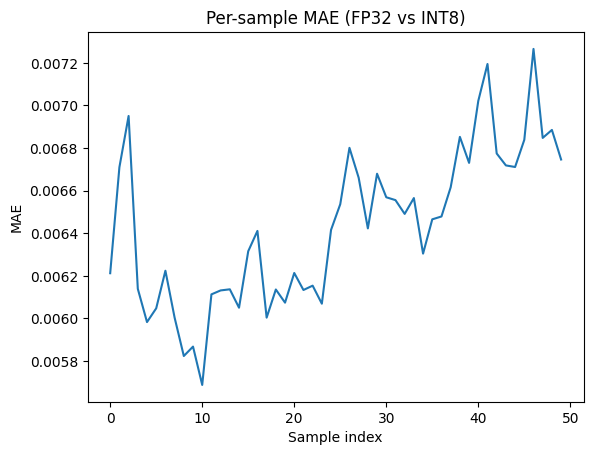

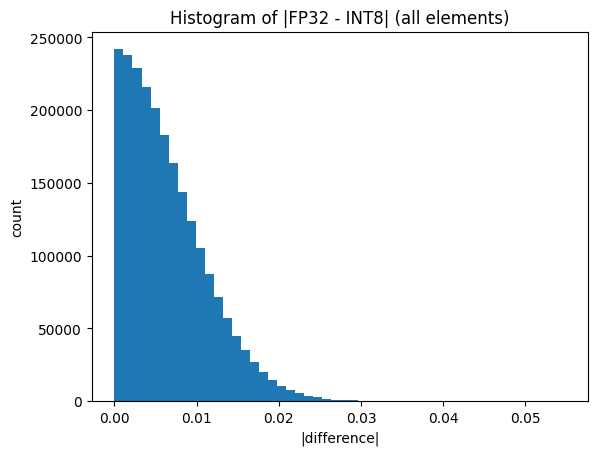

In [ ]:
# PTQ accuracy impact proxy with stronger validation
# Includes:
# 1) Larger sample size + summary stats
# 2) Per-sample drift (mean/std/max/p95)
# 3) Simple behavioral + visual sanity checks

import numpy as np
import matplotlib.pyplot as plt
import qai_hub as hub

# Increase sample size for stronger validation
N_REQUEST = 100  # can raise to 200 if have enough calibration frames

all_samples = calibration_data["input"]
N = min(N_REQUEST, len(all_samples))
assert N > 0, "calibration_data is empty. Build it in the calibration cell first."

samples = all_samples[:N]
inputs_dict = {"input": samples}

print("Submitting on-device inference for FP32...")
infer_fp32_job = hub.submit_inference_job(
    model=compiled_fp32_model,
    device=device,
    inputs=inputs_dict,
    name="ufldv2_fp32_accuracy_check",
)
out_fp32 = infer_fp32_job.download_output_data()

print("Submitting on-device inference for INT8...")
infer_int8_job = hub.submit_inference_job(
    model=compiled_int8_model,
    device=device,
    inputs=inputs_dict,
    name="ufldv2_int8_accuracy_check",
)
out_int8 = infer_int8_job.download_output_data()

# outputs
out_name_fp32 = list(out_fp32.keys())[0]
out_name_int8 = list(out_int8.keys())[0]

fp32_arr = np.array(out_fp32[out_name_fp32])
int8_arr = np.array(out_int8[out_name_int8])

print("\n=== PTQ Accuracy Proxy (On-device numeric drift) ===")
print("Samples:", N)
print("Output tensor FP32:", out_name_fp32, "shape:", fp32_arr.shape)
print("Output tensor INT8:", out_name_int8, "shape:", int8_arr.shape)

assert fp32_arr.shape == int8_arr.shape, "FP32/INT8 output shapes differ unexpectedly."

# Flatten over all dims per sample
fp32_flat = fp32_arr.reshape(fp32_arr.shape[0], -1)
int8_flat = int8_arr.reshape(int8_arr.shape[0], -1)

# Per-sample MAE
per_mae = np.mean(np.abs(fp32_flat - int8_flat), axis=1)

# Global MAE/MSE
global_mae = float(np.mean(per_mae))
global_mse = float(np.mean((fp32_flat - int8_flat) ** 2))

# Cosine similarity per sample then average
def cosine(a, b, eps=1e-12):
    num = np.sum(a * b, axis=1)
    den = np.linalg.norm(a, axis=1) * np.linalg.norm(b, axis=1) + eps
    return num / den

per_cos = cosine(fp32_flat, int8_flat)
cos_mean = float(np.mean(per_cos))

# Summary stats
p95_mae = float(np.percentile(per_mae, 95))
max_mae = float(np.max(per_mae))
std_mae = float(np.std(per_mae))

print(f"Global MAE: {global_mae:.6f}")
print(f"Global MSE: {global_mse:.6f}")
print(f"Mean cosine similarity: {cos_mean:.6f}")
print("\nPer-sample MAE stats:")
print(f"  mean: {global_mae:.6f}")
print(f"  std : {std_mae:.6f}")
print(f"  p95 : {p95_mae:.6f}")
print(f"  max : {max_mae:.6f}")

# This checks whether the top-1 index over the flattened output is preserved per sample.
fp32_arg = np.argmax(fp32_flat, axis=1)
int8_arg = np.argmax(int8_flat, axis=1)
argmax_match = float(np.mean(fp32_arg == int8_arg))

print(f"\nArgmax match rate (proxy): {argmax_match*100:.2f}%")

# Distribution of absolute differences
abs_diff = np.abs(fp32_flat - int8_flat).ravel()

print("\nQuantiles of |FP32 - INT8|:")
for q in [50, 75, 90, 95, 99]:
    print(f"  p{q}: {np.percentile(abs_diff, q):.6f}")

# Plot 1: per-sample MAE bar (first 50 samples)
plt.figure()
plt.title("Per-sample MAE (FP32 vs INT8)")
plt.xlabel("Sample index")
plt.ylabel("MAE")
plt.plot(per_mae[:min(50, len(per_mae))])
plt.show()

# Plot 2: histogram of absolute differences
plt.figure()
plt.title("Histogram of |FP32 - INT8| (all elements)")
plt.xlabel("|difference|")
plt.ylabel("count")
plt.hist(abs_diff, bins=50)
plt.show()
